In [ ]:
import pandas as pd
import numpy as np
import string as string
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os 
import math
import re
import sklearn
import shutil
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
from scipy.sparse import csr_matrix
from cvxpy import *
from numpy import matrix
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

print("Setup Complete\n")


In [74]:
# Import data :
# 1. train is reviews of movie car 2 from the IMDB DB
# 2. positive/negative words are wordlists for positive or negative pharases
sample=pd.read_csv('./review_train.csv') 
sample.columns=['username','rating','helfull','total','date','title','review']
sample['username']=sample.index
positive=pd.read_csv('positive-words.txt',header=None)
positive.columns=['words']
negative=pd.read_csv('negative-words.txt',header=None)
negative.columns=['words']
# using stopswords from nltk library
stop_words=stopwords.words('english')

In [75]:
#preprocess function  definitions 
stemmer = PorterStemmer()
# Stemming function
stem_words=lambda x: stemmer.stem(x)
# remove unwanted asscii symbols
break_into_words = lambda x : re.findall("[a-zA-Z0-9]+", x)
# ignoring stop words
skip_stop_words = lambda x: [w for w in x if w not in list(stop_words)]
# skip numerical characters
skip_numeric = lambda x : [w for w in x if not w.isnumeric()]

#apply pre-processing steps
processed_text=sample['review'].str.lower()\
        .map(break_into_words)\
        .map(skip_stop_words)\
        .map(skip_numeric)
sample['processed']=processed_text
#sample['processed'] _ for dimonstration purpuse

In [76]:
#count number of positive words
positive_words_count=processed_text.map(lambda x: len([w for w in x if w in list(positive['words'])]))
#count number of negative words
negative_words_count=processed_text.map(lambda x: len([w for w in x if w in list(negative['words'])]))
sample['positive']=positive_words_count
sample['negative']=negative_words_count
sample.head()

,username,rating,helfull,total,date,title,review,processed,positive,negative
0,0,8,26,31,19 July 2015,Why so much hate? It was okay\n,I keep reading reviews for Cars 2 and I am kin...,"[keep, reading, reviews, cars, kind, surprised...",6,7
1,1,10,15,18,1 December 2013,Great fun for all!\n,I take a completely opposite view than many of...,"[take, completely, opposite, view, many, cars,...",15,26
2,2,7,246,385,11 June 2011,"A Great Summer Film, that the whole family ca...",We all know that Pixar makes incredible movies...,"[know, pixar, makes, incredible, movies, perso...",21,7
3,3,6,105,158,24 June 2011,Not what my kids and I expected...\n,"Espionage, assassinations, sabotage of renewab...","[espionage, assassinations, sabotage, renewabl...",17,14
4,4,3,409,655,22 June 2011,Such a disappointment\n,"16 years ago, Pixar Animation Studios released...","[years, ago, pixar, animation, studios, releas...",21,33


# <font color = 'green'>Method 1<font>
**sentiment score is simply the substraction (pos.phrases - neg.phrases)**

In [77]:
#method 1 -
sample['sentiment_score_1']=sample['positive']-sample['negative']
mt1_avg_score = sample['sentiment_score_1'].mean()
print(mt1_avg_score)
sample.head()

4.342261904761905


,username,rating,helfull,total,date,title,review,processed,positive,negative,sentiment_score_1
0,0,8,26,31,19 July 2015,Why so much hate? It was okay\n,I keep reading reviews for Cars 2 and I am kin...,"[keep, reading, reviews, cars, kind, surprised...",6,7,-1
1,1,10,15,18,1 December 2013,Great fun for all!\n,I take a completely opposite view than many of...,"[take, completely, opposite, view, many, cars,...",15,26,-11
2,2,7,246,385,11 June 2011,"A Great Summer Film, that the whole family ca...",We all know that Pixar makes incredible movies...,"[know, pixar, makes, incredible, movies, perso...",21,7,14
3,3,6,105,158,24 June 2011,Not what my kids and I expected...\n,"Espionage, assassinations, sabotage of renewab...","[espionage, assassinations, sabotage, renewabl...",17,14,3
4,4,3,409,655,22 June 2011,Such a disappointment\n,"16 years ago, Pixar Animation Studios released...","[years, ago, pixar, animation, studios, releas...",21,33,-12


# <font color = 'green'>Method 2<font>
**sentiment score is the substraction from above normalized by the length of review**

In [78]:
#method 2 - 
sample['normalized_sentiment_score']=sample['sentiment_score_1']/(len(sample['processed']))
mt2_avg_score = sample['normalized_sentiment_score'].mean() # The avarage of all the reviews scores in method 2
print(mt2_avg_score)
sample.head()

0.012923398526077098


,username,rating,helfull,total,date,title,review,processed,positive,negative,sentiment_score_1,normalized_sentiment_score
0,0,8,26,31,19 July 2015,Why so much hate? It was okay\n,I keep reading reviews for Cars 2 and I am kin...,"[keep, reading, reviews, cars, kind, surprised...",6,7,-1,-0.002976
1,1,10,15,18,1 December 2013,Great fun for all!\n,I take a completely opposite view than many of...,"[take, completely, opposite, view, many, cars,...",15,26,-11,-0.032738
2,2,7,246,385,11 June 2011,"A Great Summer Film, that the whole family ca...",We all know that Pixar makes incredible movies...,"[know, pixar, makes, incredible, movies, perso...",21,7,14,0.041667
3,3,6,105,158,24 June 2011,Not what my kids and I expected...\n,"Espionage, assassinations, sabotage of renewab...","[espionage, assassinations, sabotage, renewabl...",17,14,3,0.008929
4,4,3,409,655,22 June 2011,Such a disappointment\n,"16 years ago, Pixar Animation Studios released...","[years, ago, pixar, animation, studios, releas...",21,33,-12,-0.035714


# <font color = 'green'>Method 3<font>
**sentiment score is calculated according to the ratio of positive and negative count words**

In [79]:
sample['ratio_sentiment_score']= sample['positive']/(sample['negative']+1)
mt3_avg_score = sample['ratio_sentiment_score'].mean()
print(mt3_avg_score) # The avarage of all the reviews scores in method 3
sample.head()

1.700299653693275


,username,rating,helfull,total,date,title,review,processed,positive,negative,sentiment_score_1,normalized_sentiment_score,ratio_sentiment_score
0,0,8,26,31,19 July 2015,Why so much hate? It was okay\n,I keep reading reviews for Cars 2 and I am kin...,"[keep, reading, reviews, cars, kind, surprised...",6,7,-1,-0.002976,0.750000
1,1,10,15,18,1 December 2013,Great fun for all!\n,I take a completely opposite view than many of...,"[take, completely, opposite, view, many, cars,...",15,26,-11,-0.032738,0.555556
2,2,7,246,385,11 June 2011,"A Great Summer Film, that the whole family ca...",We all know that Pixar makes incredible movies...,"[know, pixar, makes, incredible, movies, perso...",21,7,14,0.041667,2.625000
3,3,6,105,158,24 June 2011,Not what my kids and I expected...\n,"Espionage, assassinations, sabotage of renewab...","[espionage, assassinations, sabotage, renewabl...",17,14,3,0.008929,1.133333
4,4,3,409,655,22 June 2011,Such a disappointment\n,"16 years ago, Pixar Animation Studios released...","[years, ago, pixar, animation, studios, releas...",21,33,-12,-0.035714,0.617647


# <font color = 'green'>Method 4 - Vadar<font>
**<font color='blue'>here sentiment score calculated via Vadar package**</font><br>
    *- no need for text pre-processing*<br>
    *- faster method*<br>
    *- The method incorporate Tri-gram phrases processing*<br>

In [80]:
#method 4
analyser = SentimentIntensityAnalyzer()
sample['vader_score'] = sample['review'].map(lambda x: analyser.polarity_scores(x)['compound'])
sample['vader_score'][1]
mt4_avg_score = sample['vader_score'].mean()
print(mt4_avg_score)
sample.head()

0.5690583333333333


,username,rating,helfull,total,date,title,review,processed,positive,negative,sentiment_score_1,normalized_sentiment_score,ratio_sentiment_score,vader_score
0,0,8,26,31,19 July 2015,Why so much hate? It was okay\n,I keep reading reviews for Cars 2 and I am kin...,"[keep, reading, reviews, cars, kind, surprised...",6,7,-1,-0.002976,0.750000,0.9069
1,1,10,15,18,1 December 2013,Great fun for all!\n,I take a completely opposite view than many of...,"[take, completely, opposite, view, many, cars,...",15,26,-11,-0.032738,0.555556,-0.6198
2,2,7,246,385,11 June 2011,"A Great Summer Film, that the whole family ca...",We all know that Pixar makes incredible movies...,"[know, pixar, makes, incredible, movies, perso...",21,7,14,0.041667,2.625000,0.9972
3,3,6,105,158,24 June 2011,Not what my kids and I expected...\n,"Espionage, assassinations, sabotage of renewab...","[espionage, assassinations, sabotage, renewabl...",17,14,3,0.008929,1.133333,0.9764
4,4,3,409,655,22 June 2011,Such a disappointment\n,"16 years ago, Pixar Animation Studios released...","[years, ago, pixar, animation, studios, releas...",21,33,-12,-0.035714,0.617647,-0.5417


# <font color = 'green'>Preprocessing [The Whole Data Set]<font>

In [81]:
# loading the Netflix movies titles file
Net_Movies = pd.read_csv('netflix_movies2.csv' , encoding='Windows-1252', header = None)

# Casting yaer column to int type (for futher use in the following code)
Net_Movies[1] = Net_Movies[1].fillna(0)
Net_Movies[1] = Net_Movies[1].astype(int)
Net_Movies[1] = Net_Movies[1].astype(str)
Net_Movies[3] = Net_Movies[3].fillna('')
Net_Movies[4] = Net_Movies[4].fillna('')
Net_Movies[5] = Net_Movies[5].fillna('')
Net_Movies[2] = Net_Movies[2]+Net_Movies[3]+Net_Movies[4]+Net_Movies[5]
Net_Movies[2] = Net_Movies[2]+' ' + Net_Movies[1]
for i in range (len(Net_Movies)): 
    Net_Movies[2][i] = Net_Movies[2][i].replace(':','_')
Net_Movies.head()

<ipython-input-81-e2c1f85c2f85>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Net_Movies[2][i] = Net_Movies[2][i].replace(':','_')


,0,1,2,3,4,5
0,1,2003,Dinosaur Planet 2003,,,
1,2,2004,Isle of Man TT 2004 Review 2004,,,
2,3,1997,Character 1997,,,
3,4,1994,Paula Abdul's Get Up & Dance 1994,,,
4,5,2004,The Rise and Fall of ECW 2004,,,


## <font color = 'blue'>Extracting the review files of the movies that exists in both Netflix & IMDB DBs<font>

In [82]:
Net_IMDB = [] #aid list for tests
# Directory path of the IMDB movie review files (1150)
directory = r'./2_reviews_per_movie_raw'

# Runing thrughtout the dir and checking which moview are in both DBs
# & saving them into new directory called : review_per_movie_filtered
for entry in tqdm(os.scandir(directory)):
    ent_N = entry.name.replace('.csv','')
    file_name = entry.name
    original = r'./2_reviews_per_movie_raw'
    target = r'./review_per_movie_filtered'

    for i in range(len(Net_Movies)):
        if Net_Movies[2][i] == ent_N:
            if ent_N not in Net_IMDB:
                Net_IMDB.append(ent_N)
                original = original + '\\' + file_name
                target = target + '\\' + file_name
                shutil.copyfile(original, target)

1150it [04:04,  4.70it/s]


## <font color = 'blue'>Applying Vadar method in order to find sentiment scores per the filtered movies<font>

In [83]:
len(Net_IMDB)

381

In [85]:
analyser     = SentimentIntensityAnalyzer()
Movie_Name   = []
Vadar_Rating = []
Netflix_Movie_ID = []

directory = r'./review_per_movie_filtered'
for entry in tqdm(os.scandir(directory)):
    ent_N = entry.name.replace('.csv','')
    Movie_Name.append(ent_N)
    sample=pd.read_csv(entry)
    sample['vader_score'] = sample['review'].map(lambda x: analyser.polarity_scores(x)['compound'])
    Vadar_Rating.append(round((sample['vader_score'].mean()),3))
    for i in range(len(Net_Movies)):
        if Net_Movies[2][i] == ent_N:
            Netflix_Movie_ID.append(Net_Movies[0][i])

415it [41:28,  6.00s/it] 


In [86]:
# saving the movie names and scores into Dataframe
imdb_rating_scores = pd.DataFrame(list(zip(Netflix_Movie_ID,Movie_Name, Vadar_Rating)),
               columns =['Netflix_Movie_ID','Movie Name', 'Vadar Score'])

In [87]:
# creating csv file which contains calculated imdb avg score of **ALL** the movies wchich are also in the Netflix dB
imdb_rating_scores.to_csv('./imdbNet_vader_score.csv')
#imdb_rating_scores = pd.read_csv('imdbNet_vader_score.csv')

In [88]:
percent = 0 # input param (0 - 1) that specify what percent of the movies goes into the MF model
pagination = int(percent*len(imdb_rating_scores))
pagination
imdb_rating_scores.drop(imdb_rating_scores.tail(pagination).index,
        inplace = True)
imdb_rating_scores.to_csv('./imdbNet_vader_score_'+(str(percent*100))+'%_recuded.csv')

In [89]:
# Function to improve runtime
# Set movies limit
def remove_movies(file,target,keep_movies_indexes,movies_limit = 50,reviews_limit = 200):
    index_list = []
    reviews_file = open(file,'r')
    line = reviews_file.readline()
    output = []
    valid_movie = False
    movies_counter = 0
    reviews_counter = 0
    while line:
        if movies_counter == movies_limit:
            print (f"read {movies_limit} movies")
            break
        line_split = line.split(':')
        if len(line_split) > 1:
            index = int(line_split[0])
            reviews_counter = 0
            if index in keep_movies_indexes:
                movies_counter += 1
                index_list.append(index)
                valid_movie = True
            else:
                valid_movie = False
        elif valid_movie and reviews_counter < reviews_limit:
            line = line[:-1] + "," + str(index) + "\n"
            target.write(line)
            reviews_counter += 1
        line = reviews_file.readline()
    
    reviews_file.close()
    return index_list


In [90]:
start = time.time()
data_files_names = ['./combined_data_1.txt']
target = open('./combined_data_updated.txt','w')
target.write('Cust_Id,Rating,Date,Movie_Id\n')
keep_movies_indexes = pd.read_csv('imdbNet_vader_score.csv')['Netflix_Movie_ID'].values
movies_indexes = []
for file in data_files_names:
    movies_indexes += remove_movies(file,target,keep_movies_indexes)
target.close()
end = time.time()
print(f'start: {start}, end: {end},end-start: {end-start}')

read 50 movies
start: 1633210106.1879096, end: 1633210118.0975018,end-start: 11.909592151641846


In [91]:
df1 = pd.read_csv('./combined_data_updated.txt')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Cust_Id   9800 non-null   int64 
 1   Rating    9800 non-null   int64 
 2   Date      9800 non-null   object
 3   Movie_Id  9800 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 306.4+ KB


In [92]:
df1['Rating'] = df1['Rating'].astype(float)
df1['Date'] = df1['Date'].astype(str)
df1['Date'] = df1['Date'].map( lambda s : (s[:4])+(s[5:7])+(s[8:]))
df1['Date'] = df1['Date'].astype(float)
print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::100, :])
print(df1['Date'].dtype)
df = df1

Dataset 1 shape: (9800, 4)
-Dataset examples-
      Cust_Id  Rating        Date  Movie_Id
0     2423875     4.0  20000407.0       143
100   1583311     5.0  20040311.0       143
200   2050573     5.0  20050705.0       167
300     97704     3.0  20051103.0       167
400   1943087     5.0  20050606.0       175
...       ...     ...         ...       ...
9300   314837     4.0  20030625.0      2743
9400   712664     3.0  20020927.0      2771
9500   872068     4.0  20050829.0      2771
9600  1609049     4.0  20001121.0      2780
9700  2515522     3.0  20050704.0      2780

[98 rows x 4 columns]
float64


See Overview of the Data


<bound method NDFrame.head of       Cust_Id  Rating        Date  Movie_Id
0     2423875     4.0  20000407.0       143
1     1734805     5.0  20000909.0       143
2      716091     3.0  20000108.0       143
3      169485     5.0  20050708.0       143
4     1990901     5.0  20020805.0       143
...       ...     ...         ...       ...
9795   192061     4.0  20050419.0      2780
9796  2048085     3.0  20050426.0      2780
9797   501759     2.0  20050429.0      2780
9798   155803     1.0  20050521.0      2780
9799  1232734     5.0  20050531.0      2780

[9800 rows x 4 columns]>

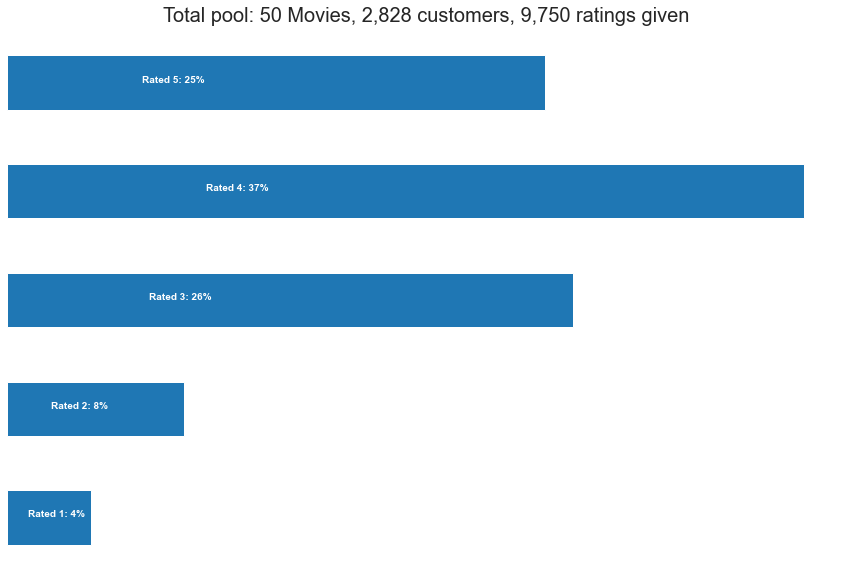

In [93]:
#Seeing the distribution of ratings given by the users
print("See Overview of the Data")
p = df.groupby('Rating')['Rating'].agg(['count'])
# get movie count
movie_count = len(movies_indexes) 
# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count
# get rating count
rating_count = df['Cust_Id'].count() - movie_count
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')
for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 
            'Rated {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), 
            color = 'white', weight = 'bold')
df.head

In [94]:
#Creating Data Matrix
df_matrix=pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_matrix.shape)

(2878, 49)


In [95]:
df.head()

,Cust_Id,Rating,Date,Movie_Id
0,2423875,4.0,20000407.0,143
1,1734805,5.0,20000909.0,143
2,716091,3.0,20000108.0,143
3,169485,5.0,20050708.0,143
4,1990901,5.0,20020805.0,143


In [96]:
df_matrix.head()

Movie_Id,143,167,175,191,199,241,311,312,442,457,...,2173,2192,2372,2395,2400,2465,2734,2743,2771,2780
Cust_Id,,,,,,,,,,,,,,,,,,,,,
769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
#Loading the Movie ID- Movie Title Mapping File
df_title = pd.read_csv('./movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print("See some Movie ID- Movie Title Mapping : \n")
print (df_title.head(8))

See some Movie ID- Movie Title Mapping : 

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?


In [98]:
print("\n\nData Cleaning Complete.\n See head of the Data Matrix:\n")
print(df_matrix.head())

n_movies = movie_count
n_customers = cust_count

print("\nNum of movies =", movie_count)
print("Num of users =", cust_count)



Data Cleaning Complete.
 See head of the Data Matrix:

Movie_Id  143   167   175   191   199   241   311   312   442   457   ...  \
Cust_Id                                                               ...   
769        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1333       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1427       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2363       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5569       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

Movie_Id  2173  2192  2372  2395  2400  2465  2734  2743  2771  2780  
Cust_Id                                                               
769        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN  
1333       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1427       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2363       NaN   NaN   NaN   NaN   NaN   NaN   N

In [99]:
#Choosing the number of latent attributes
n_attr = 200
Q = Variable((n_attr,n_movies))
P = Variable((n_attr, n_customers))

acq_data = df_matrix.fillna(0.0)
print(acq_data.head())

Movie_Id  143   167   175   191   199   241   311   312   442   457   ...  \
Cust_Id                                                               ...   
769        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1333       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1427       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2363       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5569       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

Movie_Id  2173  2192  2372  2395  2400  2465  2734  2743  2771  2780  
Cust_Id                                                               
769        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   3.0   0.0  
1333       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1427       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2363       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5569       0.0   0.0   0.0   0.0  

In [100]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations,delta = 0,vadar_score=0,beta1=0):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.beta1 = beta1
        self.iterations = iterations
        self.delta = delta
        self.vadar_score = vadar_score

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)  + self.delta*self.vadar_score # + A*imdb_rating_scores[Vader Score]
        #print(f"Initialized bias: {self.b_i}")
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        a = self.alpha
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd(a)
            mse = self.mse()
            training_process.append((i, mse))
            a = a*0.9
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self,a):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += a * (e - self.beta * self.b_u[i])
            self.b_i[j] += a * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += a * (e * self.Q[j, :] - self.beta1 * self.P[i,:])
            self.Q[j, :] += a * (e * self.P[i, :] - self.beta1 * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [101]:
#This cell works on Toy Dataset
#The next cell is for real data
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

R1= np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

#Set the number of values to replace. For example 20%:
prop = int(R.size * 0.2)

#Randomly choose indices of the numpy array:
i = [np.random.choice(range(R.shape[0])) for _ in range(prop)]
j = [np.random.choice(range(R.shape[1])) for _ in range(prop)]

#Change values with 0
R[i,j] = 0
print("Original:\n",R1)
print("Test Set:\n",R)
R=np.rint(R)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(R, R1)

print("RMSE=",mse**0.5)

print("\nTraining ...\n")

mf = MF(R, K=200, alpha=0.01, beta=0.01, iterations=10000)
training_process = mf.train()
L=np.rint(mf.full_matrix())

print("Learnt=\n",L)
msef=0.0
for i1 in range(len(i)):
    for i2 in range(len(j)):
        if R1.item(i[i1],j[i2])!=0:
            msef = msef + (R1.item((i[i1],j[i2]))-(L).item((i[i1],j[i2])))**2
msef = (msef/(len(j)*len(i)))
print("RMSE f=",msef**0.5)

Original:
 [[5 3 0 1]
 [4 0 0 1]
 [1 1 0 5]
 [1 0 0 4]
 [0 1 5 4]]
Test Set:
 [[5 3 0 0]
 [4 0 0 1]
 [1 1 0 0]
 [1 0 0 4]
 [0 1 0 4]]
RMSE= 1.5968719422671311

Training ...

Learnt=
 [[3. 3. 3. 3.]
 [3. 2. 2. 3.]
 [2. 2. 2. 2.]
 [3. 2. 2. 3.]
 [3. 2. 3. 3.]]
RMSE f= 1.8371173070873836


In [103]:
#This cell works on Real DataSet

R = np.array(acq_data)

R1= np.array(acq_data)

#Set the number of values to replace. For example 20%:
prop = int(R.size * 0.2)

#Randomly choose indices of the numpy array:
i = [np.random.choice(range(R.shape[0])) for _ in range(prop)]
j = [np.random.choice(range(R.shape[1])) for _ in range(prop)]

#Change values with 0
R[i,j] = 0
print("Original:\n",R1)
print("Test Set:\n",R)
R=np.rint(R)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(R, R1)

print("RMSE=",mse**0.5)

print("\nTraining ...\n")

mf = MF(R, K=20, alpha=0.01, beta=0.01, iterations=100)
training_process = mf.train()
L=np.rint(mf.full_matrix())

print("\nDone\n")

Original:
 [[0. 0. 0. ... 0. 3. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Test Set:
 [[0. 0. 0. ... 0. 3. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
RMSE= 0.4294557209421558

Training ...


Done



Minimizing Error on Training Set:



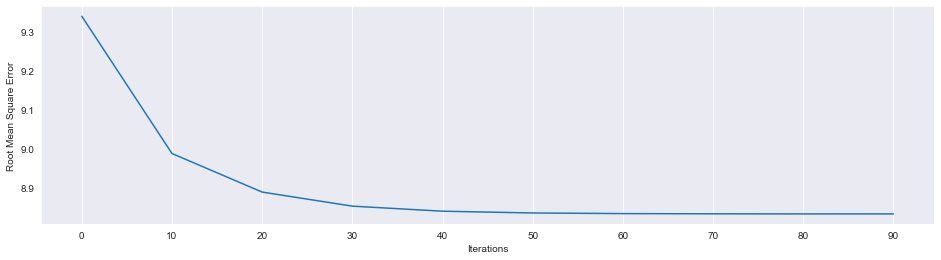

In [104]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
x = x[::10]
y = y[::10]
plt.figure(figsize=((16,4)))
plt.plot(x, np.sqrt(y))
plt.xticks(x, x)

print("Minimizing Error on Training Set:\n")
plt.xlabel("Iterations")
plt.ylabel("Root Mean Square Error")
plt.grid(axis="y")

In [105]:
imdb_rating_scores_filtered = imdb_rating_scores[imdb_rating_scores['Netflix_Movie_ID'] < movies_indexes[-1]]

(2878, 49)
Training ... with delta 0.0
Done
78.85271383060244
Training ... with delta 0.2
Done
79.0331864428803
Training ... with delta 0.4
Done
79.10130471188452
Training ... with delta 0.6000000000000001
Done
79.00711103701458
Training ... with delta 0.8
Done
78.98176239744488
Training ... with delta 1.0
Done
79.06904372115633


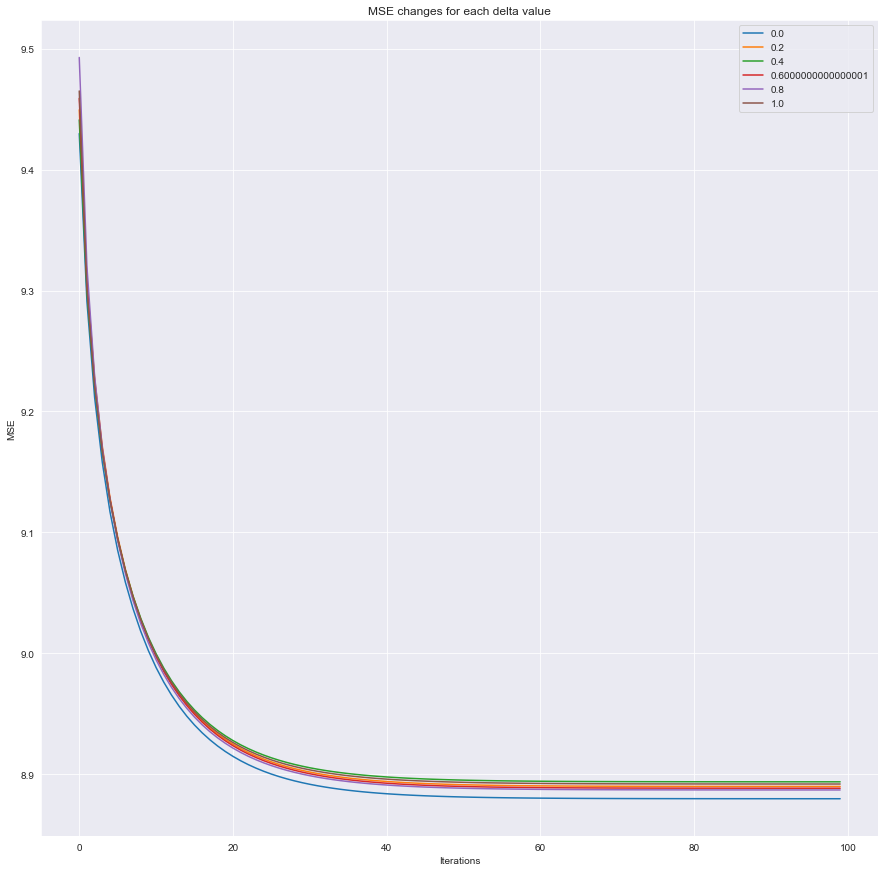

In [106]:
num_of_weights = 6
weights = np.linspace(0, 1, num_of_weights)
#fig, axs = plt.subplots(num_of_weights,figsize=((15,15)))

imdb_rating_scores_filtered['Vadar Score']
vadar_scores = imdb_rating_scores_filtered['Vadar Score'].values
print (R.shape)

fig = plt.figure(figsize=(15,15))
for i, delta in enumerate(weights):
    print(f"Training ... with delta {delta}")
    mf = MF(R, K=2, alpha=0.01, beta=0.01, iterations=100,delta = delta,vadar_score = vadar_scores)
    training_process = mf.train()
    L=np.rint(mf.full_matrix())
    print("Done")
    x = [x for x, y in training_process]
    y = [y for x, y in training_process]
    x = x[::1]
    y = y[::1]
    print(y[-1])
    plt.plot(x, np.sqrt(y))

plt.title("MSE changes for each delta value")
plt.xlabel("Iterations")
plt.ylabel("MSE")

plt.legend(weights)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [36]:
def plot_mf(R,K,iterations,num_of_weights=6):
    weights = np.linspace(0, 4/K, num_of_weights)
    fig = plt.figure(figsize=(15,10))
    for i, delta in enumerate(weights):
        mf = MF(R, K=K, alpha=0.007, beta=0.005, iterations=iterations,delta = delta,vadar_score = vadar_scores,beta1=0.015)
        training_process = mf.train()
        L=np.rint(mf.full_matrix())
        x = [x for x, y in training_process]
        y = [y for x, y in training_process]
        x = x[::1]
        y = y[::1]
        plt.plot(x, np.sqrt(y))

    plt.title(f"MSE changes for each delta value - K = {K}")
    plt.xlabel("Iterations")
    plt.ylabel("MSE")

    plt.legend(weights)
    plt.subplots_adjust(hspace=0.3)
    plt.show()

K=2,iterations=30,num_of_weights=5


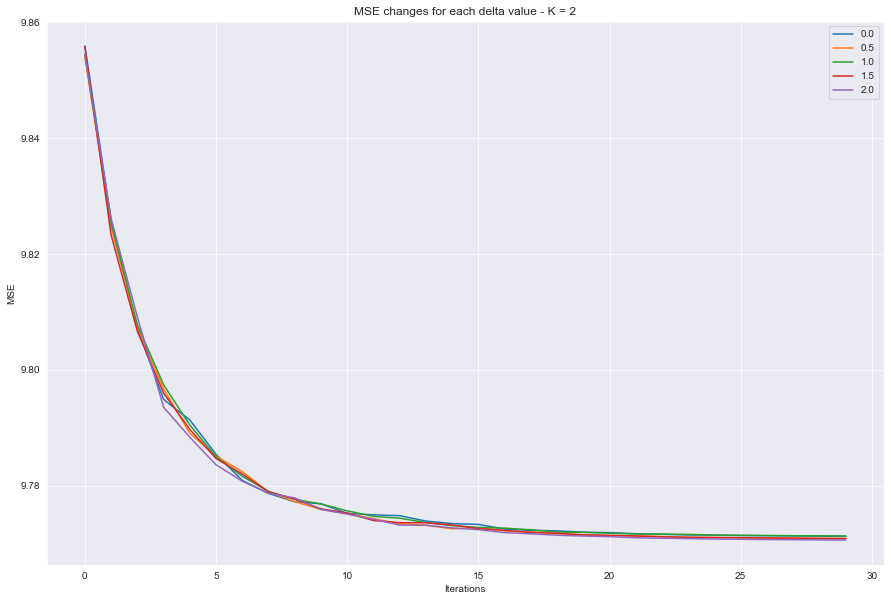

In [37]:
print("K=2,iterations=30,num_of_weights=5")
plot_mf(R,K=2,iterations=30,num_of_weights=5)

K=10,iterations=30,num_of_weights=5


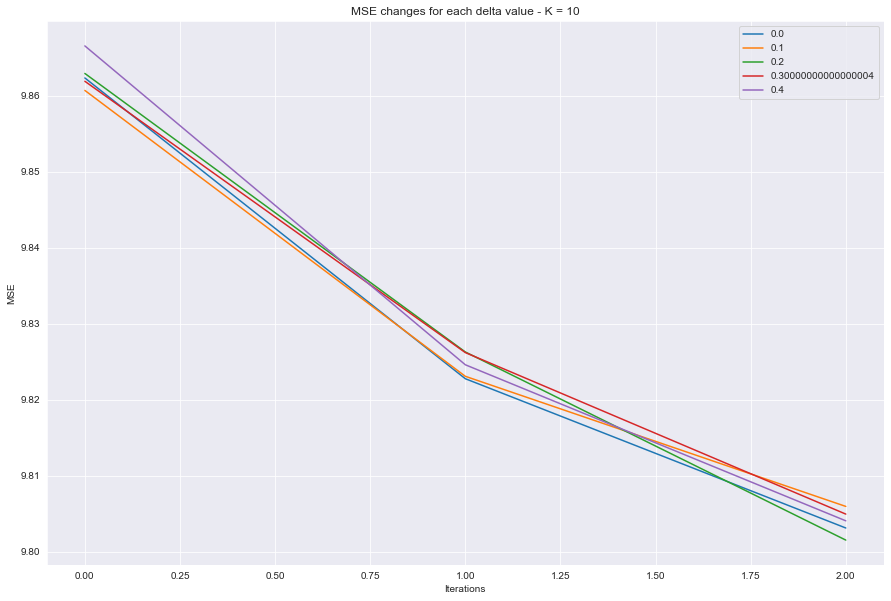

In [38]:
print("K=10,iterations=30,num_of_weights=5")
plot_mf(R,K=10,iterations=3,num_of_weights=5)

K=10,iterations=30,num_of_weights=5


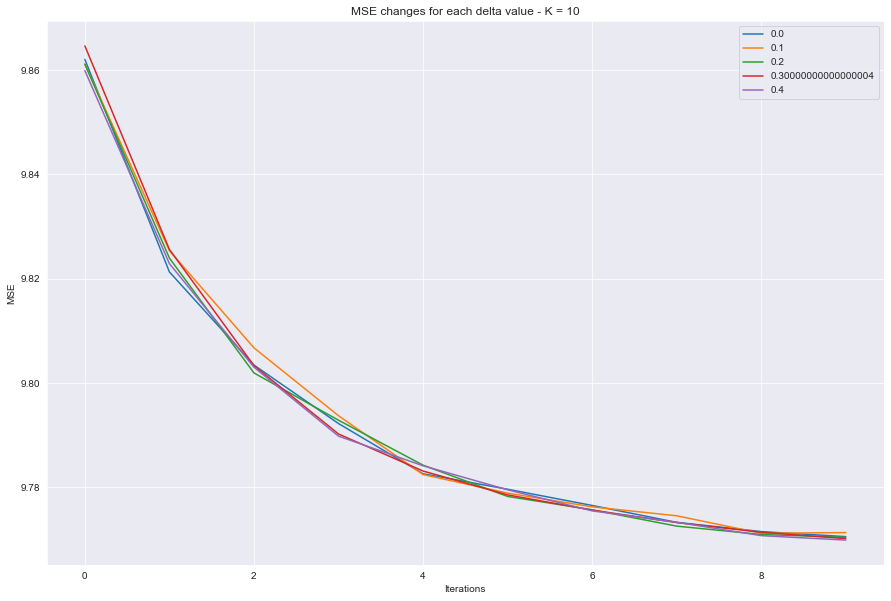

In [39]:
print("K=10,iterations=30,num_of_weights=5")
plot_mf(R,K=10,iterations=10,num_of_weights=5)

K=2,iterations=100,num_of_weights=5


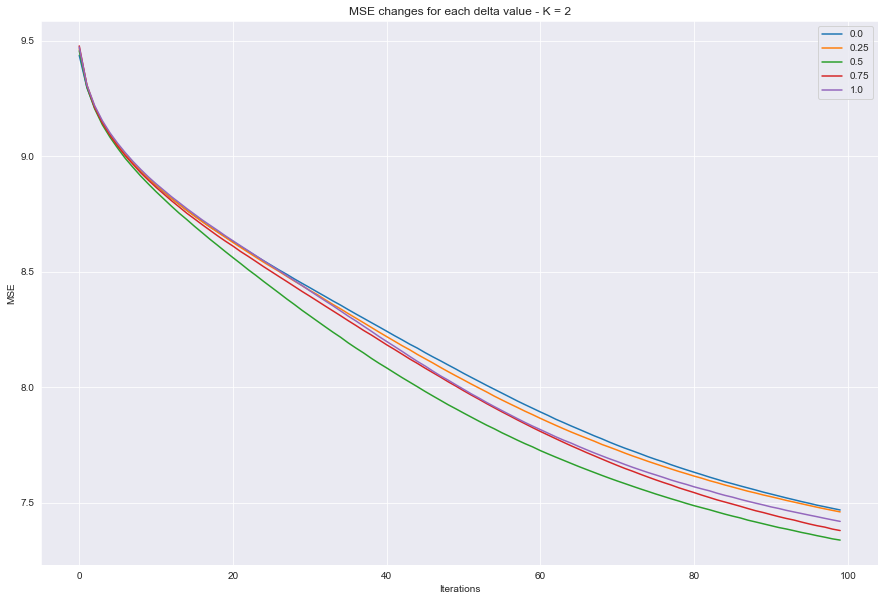

In [33]:
print("K=2,iterations=100,num_of_weights=5")
plot_mf(R,K=2,iterations=100,num_of_weights=5)


K=20,iterations=100,num_of_weights=5


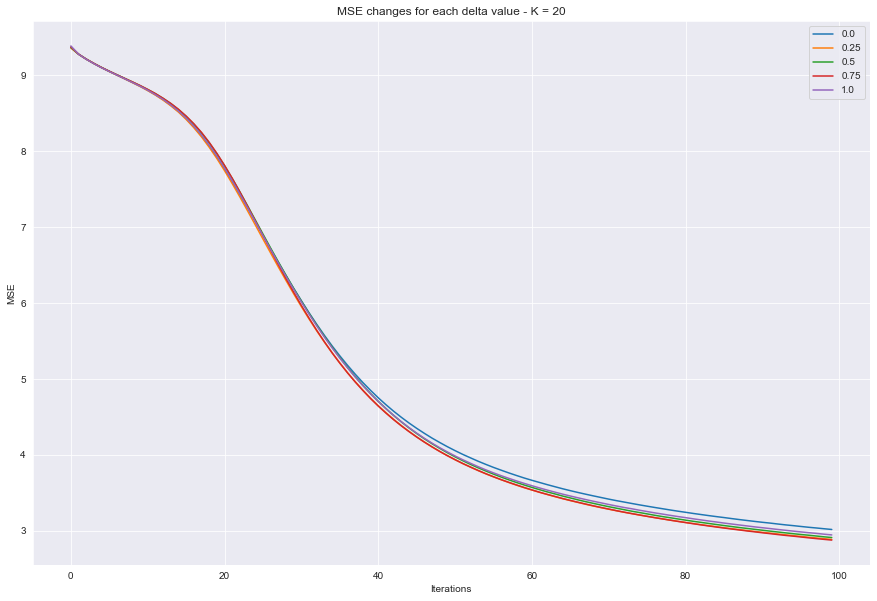

In [35]:
print("K=20,iterations=100,num_of_weights=5")
plot_mf(R,K=20,iterations=100,num_of_weights=5)

K=50,iterations=100,num_of_weights=5


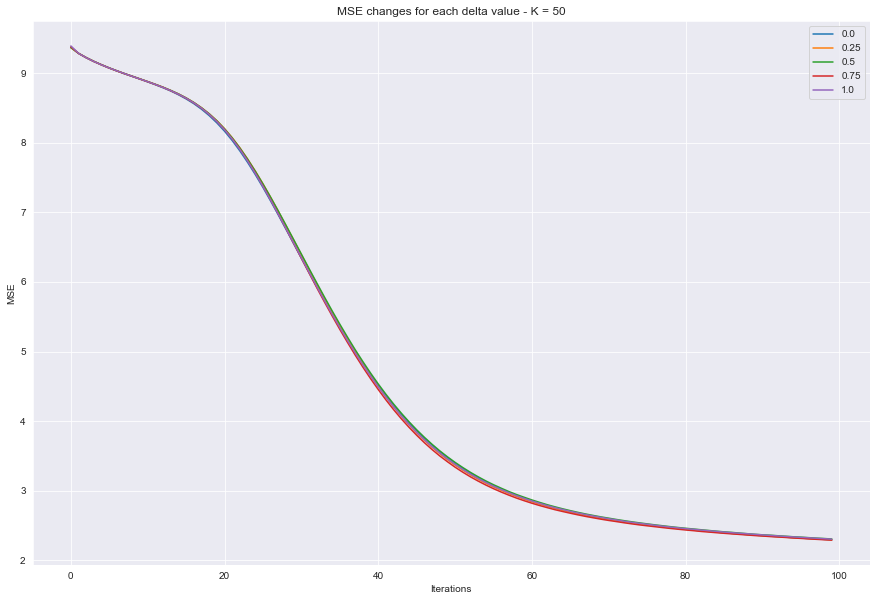

In [36]:
print("K=50,iterations=100,num_of_weights=5")
plot_mf(R,K=50,iterations=100,num_of_weights=5)


K=100,iterations=100,num_of_weights=5


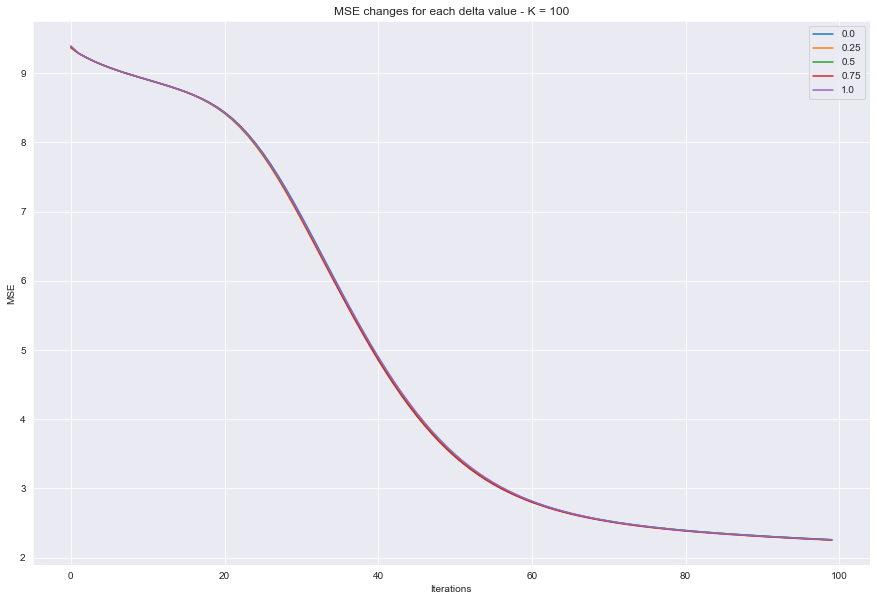

In [37]:
print("K=100,iterations=100,num_of_weights=5")
plot_mf(R,K=100,iterations=100,num_of_weights=5)

K=2,iterations=10,num_of_weights=5


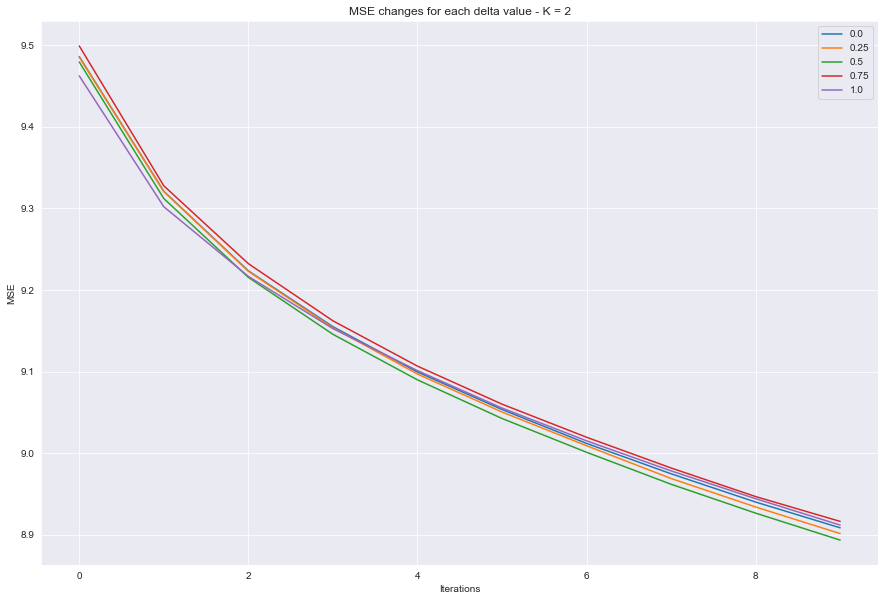

In [38]:
print("K=2,iterations=10,num_of_weights=5")
plot_mf(R,K=2,iterations=10,num_of_weights=5)




K=2,iterations=100,num_of_weights=5


KeyboardInterrupt: 

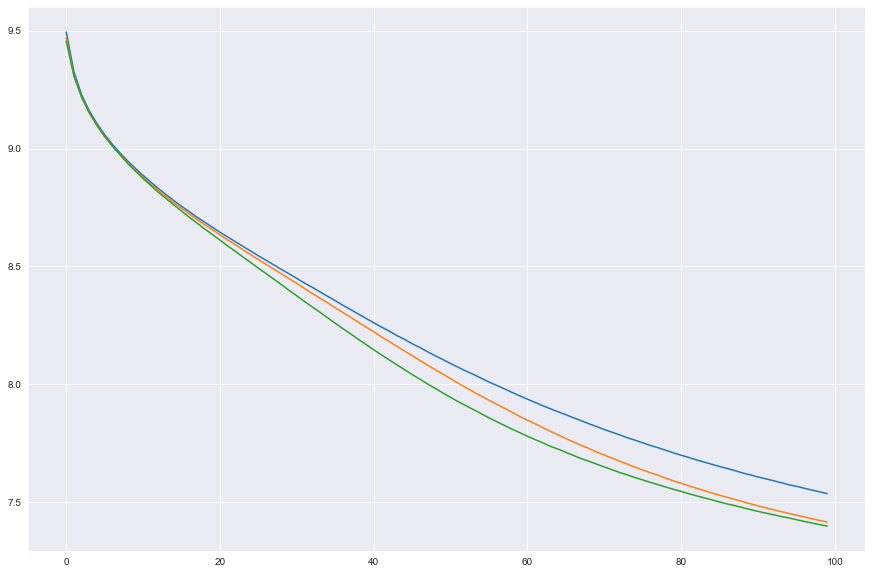

In [39]:
print("K=2,iterations=100,num_of_weights=5")
plot_mf(R,K=2,iterations=100,num_of_weights=5)

In [ ]:
print("K=2,iterations=200,num_of_weights=5")
plot_mf(R,K=2,iterations=200,num_of_weights=5)

In [ ]:
print("K=2,iterations=300,num_of_weights=5")
plot_mf(R,K=2,iterations=300,num_of_weights=5)

In [ ]:
print("Learnt=\n",mf.full_matrix())
print("\nRating predictions=\n",L)

print()
print("P x Q:")
print(mf.full_matrix())
print()
print("Global bias:")
print(mf.b)
print()
print("User bias:")
print(mf.b_u)
print()
print("Item bias:")
print(mf.b_i)

print("\nFinding Error on test set...\n")
msef=0.0
for i1 in range(len(i)):
    for i2 in range(len(j)):
        if R1.item(i[i1],j[i2])!=0:
            msef = msef + (R1.item((i[i1],j[i2]))-(L).item((i[i1],j[i2])))**2
msef = (msef/(len(j)*len(i)))
print("RMSE f=",msef**0.5)

In [49]:
# start = time.time()
# movies_indexes = remove_movies()
# end = time.time()
# print(f'start: {start}, end: {end},end-start: {end-start}')
def plot_mf2(R,K,iterations,num_of_weights=6):
    time_iterations = []
    print(f"K={K},iterations={iterations},num_of_weights={num_of_weights}")
    weights = np.linspace(0, 4, num_of_weights)
    fig = plt.figure(figsize=(15,10))
    for i, delta in enumerate(weights):
        start = time.time()
        mf = MF(R, K=K, alpha=0.007, beta=0.005, iterations=iterations,delta = delta,vadar_score = vadar_scores,beta1=0.015)
        training_process = mf.train()
        L=np.rint(mf.full_matrix())
        x = [x for x, y in training_process]
        y = [y for x, y in training_process]
        x = x[::1]
        y = y[::1]
        plt.plot(x, np.sqrt(y))
        end = time.time()
        time_iterations.append(end-start)
    print(f"-----run time for each delta value-----")
    print(f"Iterations mean time: {np.mean(time_iterations)}")
    print(f"Iterations total time: {5*np.mean(time_iterations)}")
    plt.title(f"MSE changes for each delta value - K = {K}")
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")

    plt.legend(weights)
    plt.subplots_adjust(hspace=0.3)
    plt.show()

K=10,iterations=3,num_of_weights=5
-----run time for each delta value-----
Iterations mean time: 7.144365215301514
Iterations total time: 35.72182607650757


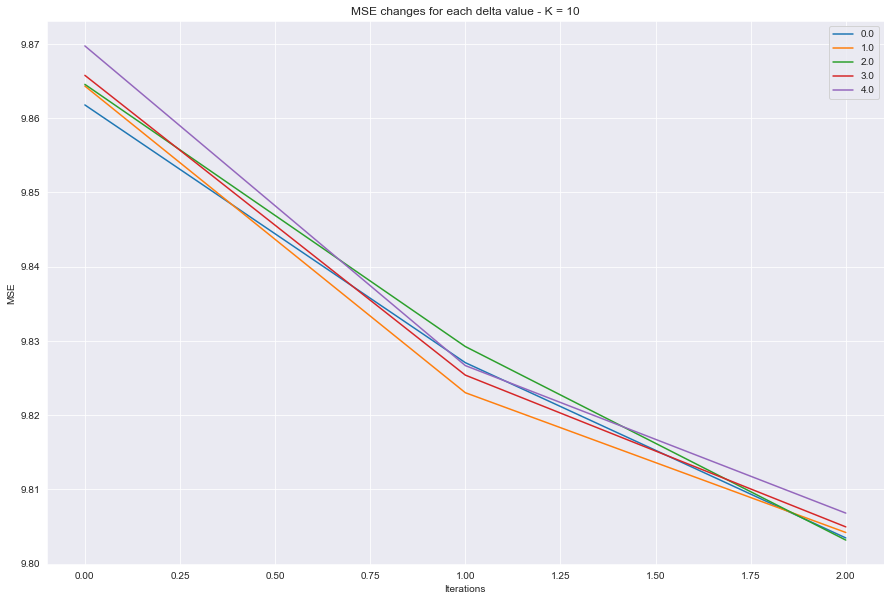

In [50]:
#print("K=10,iterations=3,num_of_weights=5")
plot_mf2(R,K=10,iterations=3,num_of_weights=5)

K=10,iterations=10,num_of_weights=5
-----run time for each delta value-----
Iterations mean time: 15.746863269805909
Iterations total time: 78.73431634902954


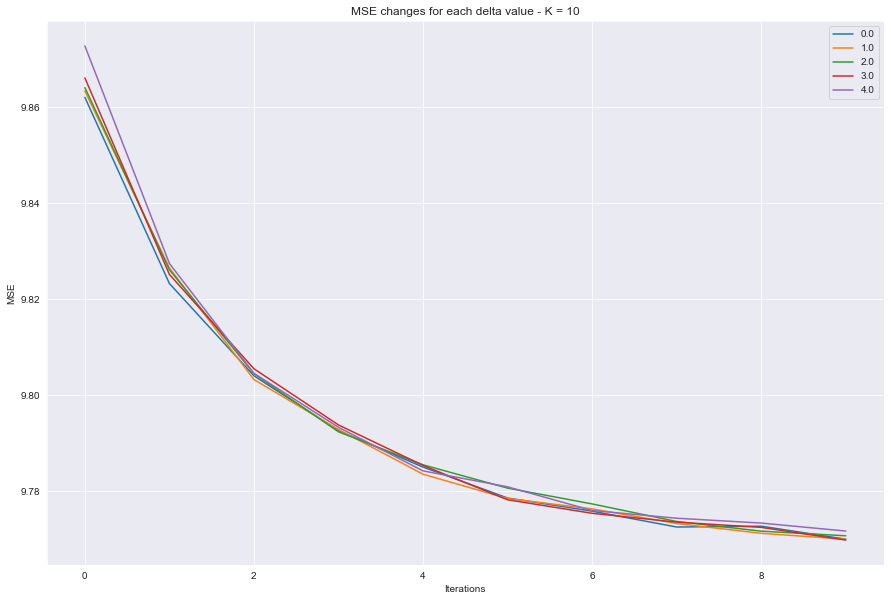

In [51]:
#print("K=10,iterations=10,num_of_weights=5")
plot_mf2(R,K=10,iterations=10,num_of_weights=5)

K=10,iterations=100,num_of_weights=3
-----run time for each delta value-----
Iterations mean time: 62.592210843012886
Iterations total time: 312.96105421506445


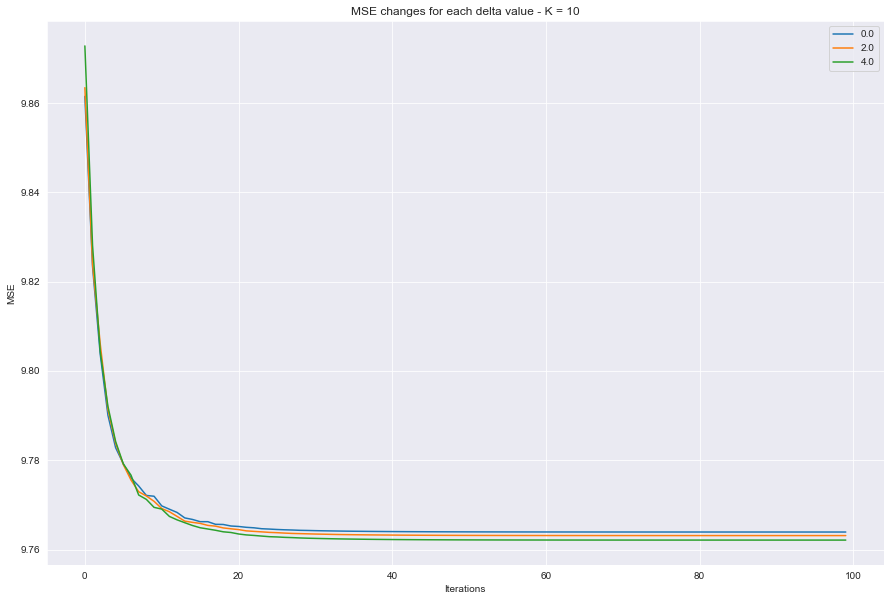

In [52]:
#print("K=10,iterations=100,num_of_weights=5")
plot_mf2(R,K=10,iterations=100,num_of_weights=3)

K=20,iterations=10,num_of_weights=5
-----run time for each delta value-----
Iterations mean time: 51.46287144554986
Iterations total time: 257.31435722774927


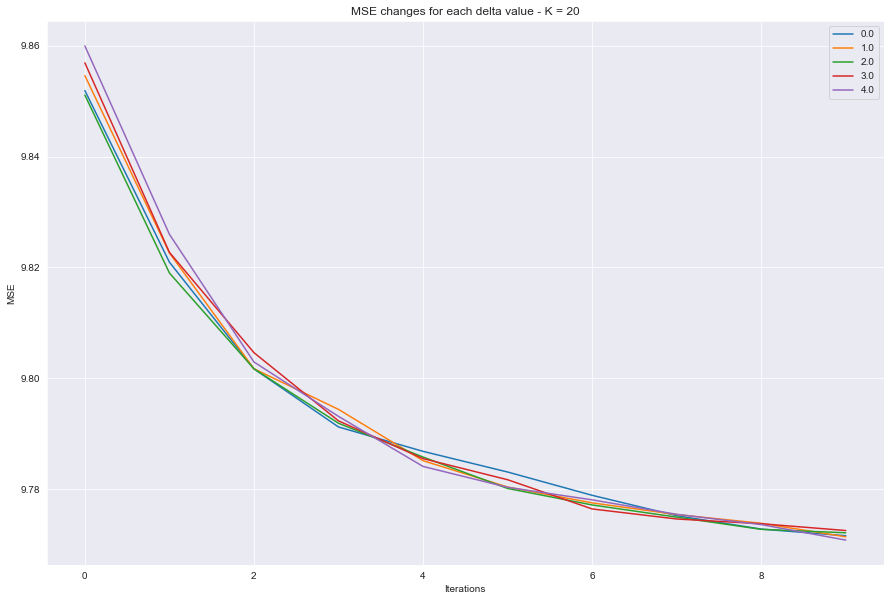

In [53]:
#print("K=20,iterations=10,num_of_weights=5")
plot_mf2(R,K=20,iterations=10,num_of_weights=5)

K=50,iterations=10,num_of_weights=5
-----run time for each delta value-----
Iterations mean time: 41.53475786958422
Iterations total time: 207.6737893479211


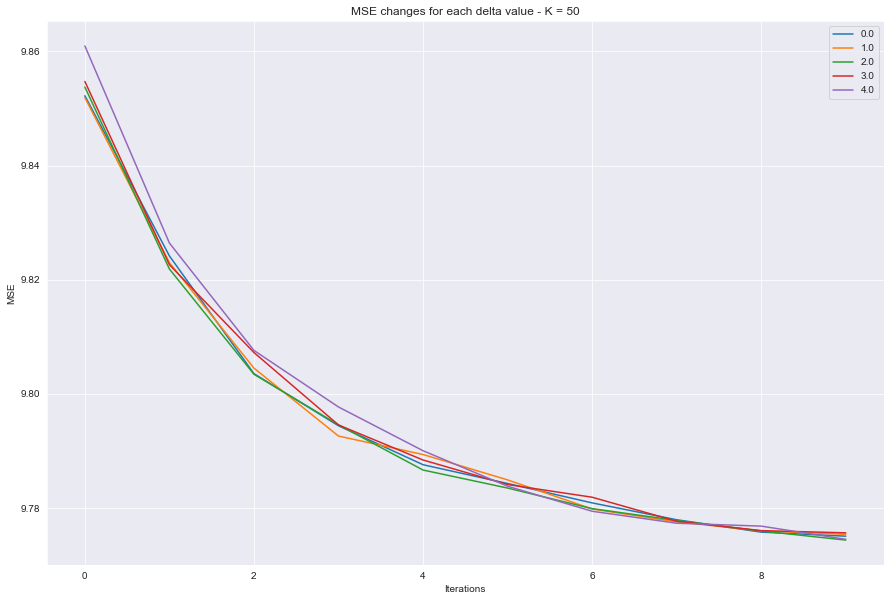

In [55]:
#print("K=20,iterations=10,num_of_weights=5")
plot_mf2(R,K=50,iterations=10,num_of_weights=5)

K=50,iterations=100,num_of_weights=3
-----run time for each delta value-----
Iterations mean time: 58.87657972305052
Iterations total time: 294.3828986152526


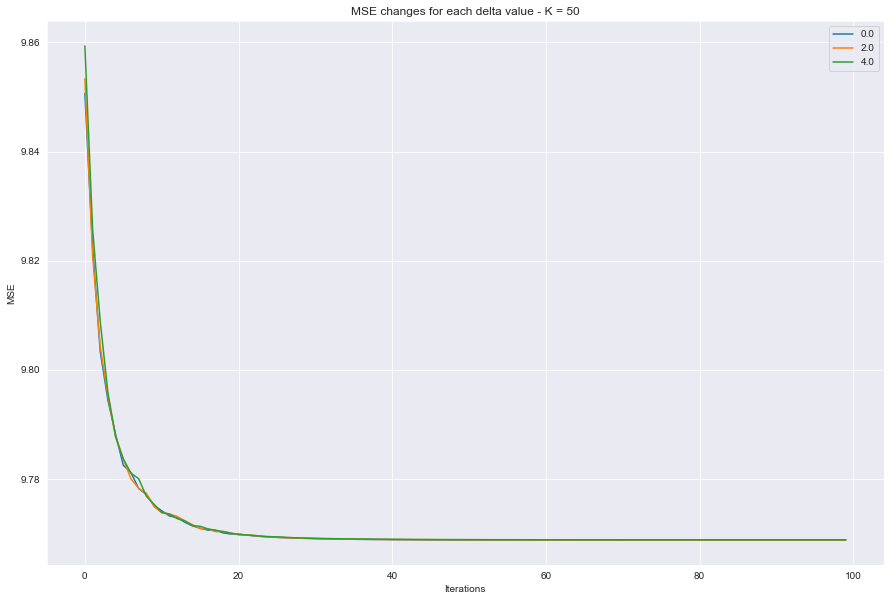

In [56]:
#print("K=20,iterations=10,num_of_weights=5")
plot_mf2(R,K=50,iterations=100,num_of_weights=3)

In [107]:
def plot_mf_rmse(R,K,iterations,num_of_weights=6):
    time_iterations = []
    print(f"K={K},iterations={iterations},num_of_weights={num_of_weights}")
    weights = np.linspace(0, 4, num_of_weights)
    fig = plt.figure(figsize=(15,10))
    for i, delta in enumerate(weights):
        start = time.time()
        mf = MF(R, K=K, alpha=0.007, beta=0.005, iterations=iterations,delta = delta,vadar_score = vadar_scores,beta1=0.015)
        training_process = mf.train()
        L=np.rint(mf.full_matrix())
        x = [x for x, y in training_process]
        y = [y for x, y in training_process]
        x = x[::1]
        y = y[::1]
        plt.plot(x, np.sqrt(y))
        end = time.time()
        time_iterations.append(end-start)
    print(f"-----run time for each delta value-----")
    print(f"Iterations mean time: {np.mean(time_iterations)}")
    print(f"Iterations total time: {5*np.mean(time_iterations)}")
    plt.title(f"RMSE changes for each delta value - K = {K}")
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")

    plt.legend(weights)
    plt.subplots_adjust(hspace=0.3)
    plt.show()

K=10,iterations=3,num_of_weights=5
-----run time for each delta value-----
Iterations mean time: 1.0814457893371583
Iterations total time: 5.407228946685791


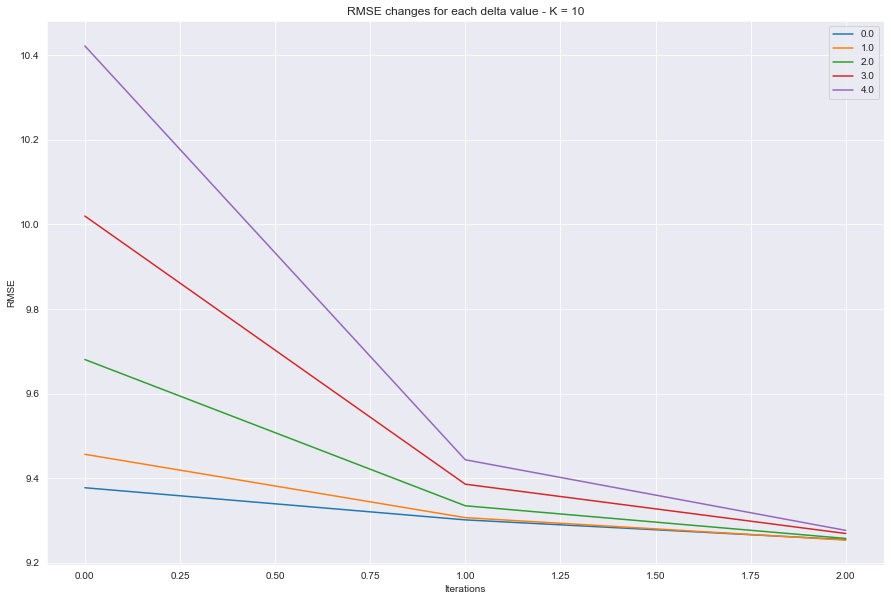

In [113]:
plot_mf_rmse(R,K=10,iterations=3,num_of_weights=5)

K=10,iterations=10,num_of_weights=5
-----run time for each delta value-----
Iterations mean time: 3.1632703304290772
Iterations total time: 15.816351652145386


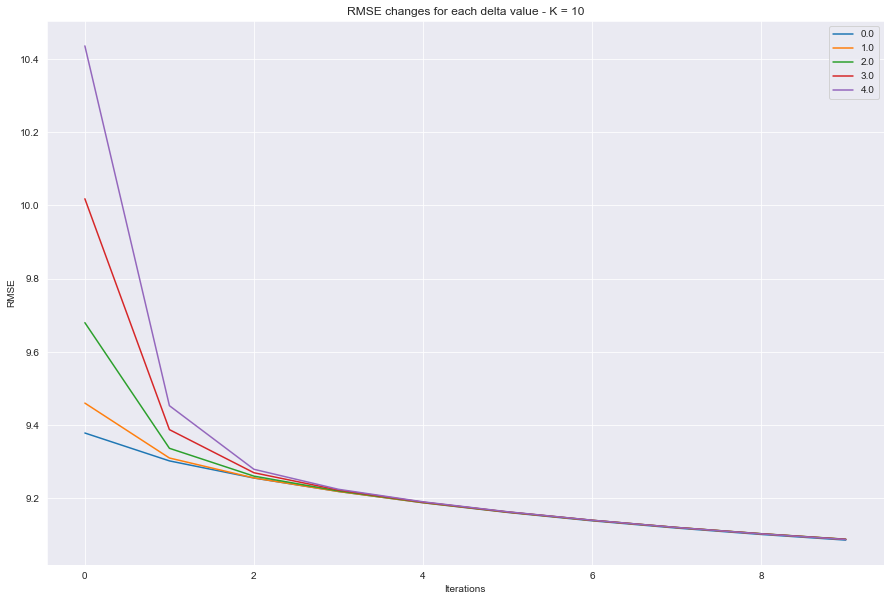

In [109]:
plot_mf_rmse(R,K=10,iterations=10,num_of_weights=5)

K=10,iterations=100,num_of_weights=3
-----run time for each delta value-----
Iterations mean time: 31.041267156600952
Iterations total time: 155.20633578300476


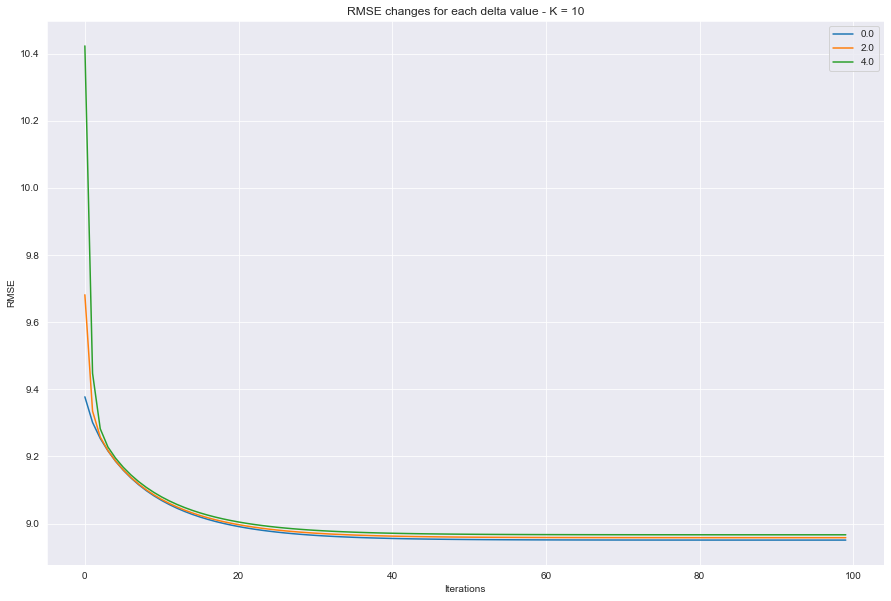

In [110]:
plot_mf_rmse(R,K=10,iterations=100,num_of_weights=3)

K=50,iterations=10,num_of_weights=5
-----run time for each delta value-----
Iterations mean time: 3.205809307098389
Iterations total time: 16.029046535491943


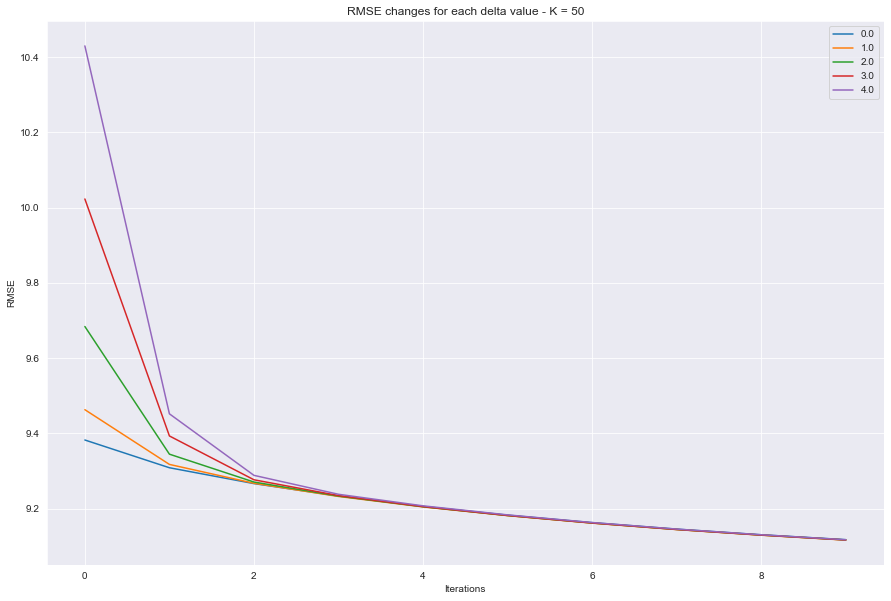

In [111]:
plot_mf_rmse(R,K=50,iterations=10,num_of_weights=5)

K=50,iterations=100,num_of_weights=3
-----run time for each delta value-----
Iterations mean time: 30.487021605173748
Iterations total time: 152.43510802586874


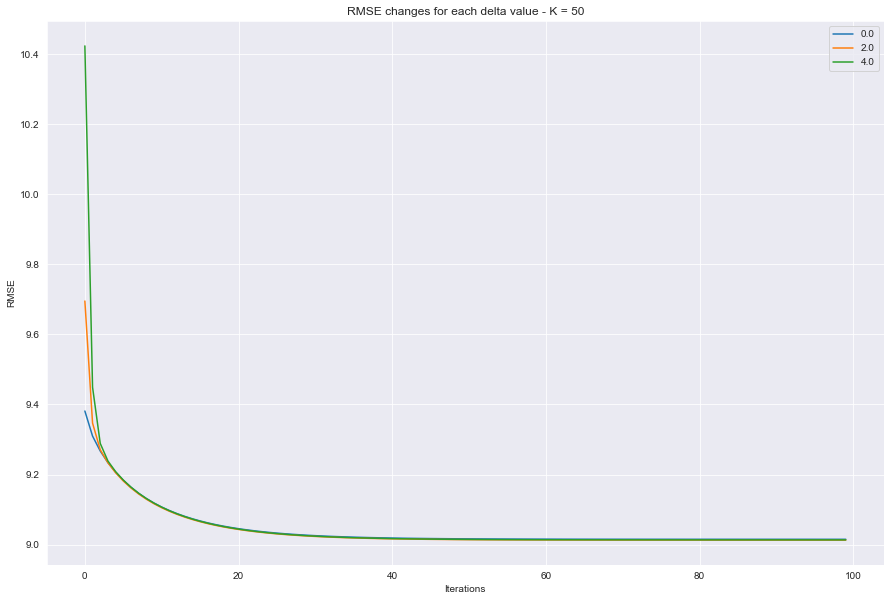

In [112]:
plot_mf_rmse(R,K=50,iterations=100,num_of_weights=3)